In [31]:
import matplotlib.pyplot as plt
import numpy as np
from lowEBMs.Packages.Configuration import importer, add_sellersparameters, parameterinterpolatorstepwise, reset
#from lowEBMs.Packages.Configuration import import_parallelparameter, allocate_parallelparameter, write_parallelparameter
from lowEBMs.Packages.Variables import variable_importer, Vars, reset, trackerreset, datareset
from lowEBMs.Packages.RK4 import rk4alg, controlrun
from lowEBMs.Packages.ModelEquation import model_equation
#from lowEBMs.Packages.Variables import 
#from lowEBMs.Packages.Functions import plotmeanstd
from lowEBMs.Packages.Optimization import coremodule

from lowEBMs import update_plotstyle, moving_average, constants
import builtins
import matplotlib
update_plotstyle()
matplotlib.rcParams['lines.linewidth']=1.1

In [2]:
time_HADCM3_str=np.genfromtxt('Data/gmt_hadcm3.csv',usecols=[0],delimiter=',',skip_header=1,dtype='str',unpack=True,encoding='ISO-8859-1')
time_HADCM3=np.zeros(len(time_HADCM3_str))
for i in range(len(time_HADCM3_str)):
    if time_HADCM3_str[i][-4]=='.':
        year=float(time_HADCM3_str[i][-3:])
    if time_HADCM3_str[i][-5]=='.':
        year=float(time_HADCM3_str[i][-4:])
    if time_HADCM3_str[i][4]=='.':
        month=(float(time_HADCM3_str[i][3:5])-1)/12
    if time_HADCM3_str[i][5]=='.':
        month=(float(time_HADCM3_str[i][3:5])-1)/12
    day=float(time_HADCM3_str[i][:2])/365
    time_HADCM3[i]=year+month+day
GMT_HADCM3=np.genfromtxt('Data/gmt_hadcm3.csv',usecols=[17],delimiter=',',skip_header=1,unpack=True,encoding='ISO-8859-1')
order=np.argsort(time_HADCM3)
GMT_HADCM3_smoothed=moving_average(GMT_HADCM3[order],12)

In [32]:
Year_volc, CWL_GMT,  EVA_GMT, CWLcorr_GMT=np.genfromtxt('Data/Volc_800_2000.txt',skip_header=1,unpack=True)
#Year_NorESM, SO4_FORC, SAT_GISS, SAT_VOLC, SAT_ZERO, SAT_AFIT, SAT_TREN= \
#np.genfromtxt('Data/NorESM_Pinatubo_GMST_response.txt',skip_header=1,unpack=True)
Year_volc_1800_1850=Year_volc[int(1000*365/4):int(1040*365/4)]
Year_volc_1808_1858=Year_volc[int(1008*365/4):int(1048*365/4)]
EVA_GMT_1800_1850=EVA_GMT[int(1000*365/4):int(1040*365/4)]
EVA_GMT_1808_1858=EVA_GMT[int(1008*365/4):int(1048*365/4)]
Lat_10,ZMT_10=np.loadtxt('Data/ERA_ZMT_Mean_10deginterpolated.txt')

In [33]:
def coremodule(config,P0,P_pert,Pmin,Pmax,labels,ZMT,GMT,grid,maxlength,targetmode,target,targetfunction,ratio_ZMT_GMT,elevation,precision,num_paras,gamma0,control,controlconfig):
    from tqdm import tqdm, tnrange
    
    F=np.reshape(np.zeros(maxlength*(2*num_paras+1)),(maxlength,2*num_paras+1))
    dF=np.reshape(np.zeros(maxlength*(num_paras)),(maxlength,num_paras))
    P=np.reshape(np.zeros(maxlength*(num_paras)),(maxlength,num_paras))
    Ptrans=np.reshape(np.zeros(maxlength*(num_paras)),(maxlength,num_paras))
    gamma=np.zeros(maxlength)
    
    if targetmode=='Single':
        dataout=np.reshape(np.zeros(maxlength*(2*num_paras+1)),(maxlength,(2*num_paras+1)))
    elif targetmode=='ZMT':
        dataout=np.reshape(np.zeros(maxlength*len(grid)*(2*num_paras+1)),(maxlength,(2*num_paras+1),len(grid)))
    elif targetmode=='GMT':
        dataout=np.reshape(np.zeros(maxlength*int(number_of_integration/data_readout)*(2*num_paras+1)),(maxlength,(2*num_paras+1),int(number_of_integration/data_readout)))
    elif targetmode=='Coupled':
        dataout_ZMT=np.reshape(np.zeros(maxlength*len(grid)*(2*num_paras+1)),(maxlength,(2*num_paras+1),len(grid)))
        dataout_GMT=np.reshape(np.zeros(maxlength*int(number_of_integration/data_readout)*(2*num_paras+1)),(maxlength,(2*num_paras+1),int(number_of_integration/data_readout)))     
    for i in tnrange(maxlength):
        print('Iteration no.'+str(i))
        if i==0:
            P[i]=P0
            Ptrans[i]=(P0-Pmin)/(Pmax-Pmin)
            Ptrans_pert=Ptrans[i]*P_pert[0]/P0[0]

        if targetmode=='Coupled':
            data_ZMT,data_GMT=run_model(config,P[i],P_pert,labels,ZMT,GMT,targetmode,control,controlconfig,grid,elevation)
            dataout_ZMT[i]=data_ZMT
            dataout_GMT[i]=data_GMT
        else:
            data=run_model(config,P[i],P_pert,labels,ZMT,GMT,targetmode,control,controlconfig,grid,elevation)
            dataout[i]=data
            
        if targetmode=='Coupled':
            target_ZMT=target['ZMT']
            target_GMT=target['GMT']
            F_ZMT=target_comparison(data_ZMT,'ZMT',target_ZMT,targetfunction,num_paras,grid)
            F_GMT=target_comparison(data_GMT,'GMT',target_GMT,targetfunction,num_paras,grid)
            F[i]=ratio_ZMT_GMT*F_ZMT+(1-ratio_ZMT_GMT)*F_GMT
        else:
            F[i]=target_comparison(data,targetmode,target,targetfunction,num_paras,grid)

        dF[i]=local_gradient(F[i],Ptrans_pert)
        #dF[i]=local_gradient(F[i],P_pert)
        if i==0:
            gamma[i]=gamma0
        else:
            #gamma[i]=step_weighting(dF[i-1],dF[i],P[i-1],P[i])
            gamma[i]=step_weighting(dF[i-1],dF[i],Ptrans[i-1],Ptrans[i])
            
        if precision_check(dF[0],dF[i],precision):
            print('stop',i)
            P=P[:i]
            Ptrans=Ptrans[:i]
            F=F[:i]
            dF=dF[:i]
            gamma=gamma[:i]
            break
                
        #P_next=new_parameters(P[i],gamma[i],dF[i])        
        Ptrans_next=new_parameters(Ptrans[i],gamma[i],dF[i])

        for k in range(num_paras):
            if Ptrans_next[k]<0:
                Ptrans_next[k]=0.
            if Ptrans_next[k]>1:
                Ptrans_next[k]=1.

        if i<maxlength-1:
            Ptrans[i+1]=Ptrans_next
            P[i+1]=Pmin+Ptrans_next*(Pmax-Pmin)
            print(F[i])
            print(gamma[i])
            print(P[i+1])
            
        if targetmode=='Coupled':
            dataout=[dataout_ZMT,dataout_GMT]
            
    return F, dF, P , Ptrans, gamma, dataout
    
def target_comparison(data,targetmode,target,targetfunction,num_paras,grid):
    F=np.zeros(2*num_paras+1)
    if targetfunction=='LeastSquare':
        if targetmode=='Single':
            F=(np.array(data)-target)**2
        elif targetmode=='ZMT':
            for i in range(len(F)):
                if len(data[i])==len(target):
                    F[i]=np.sum(((data[i]-target)*np.cos(grid*np.pi/180)/np.mean(np.cos(grid*np.pi/180)))**2)
                elif len(data[i])==len(F):
                    F[i]=np.sum(((data[:,i]-target)*np.cos(grid*np.pi/180)/np.mean(np.cos(grid*np.pi/180)))**2)
        elif targetmode=='GMT':
            for i in range(len(F)):
                F[i]=np.sum((data[i]-target)**2)

    return F

def local_gradient(F,P_pert):
    dF=np.zeros(len(P_pert))
    for k in range(len(P_pert)):
        dF[k]=(F[2*(k+1)-1]-F[2*(k+1)])/(2*P_pert[k])
    return dF

def step_weighting(dF0,dF1,P0,P1):
    gamma=np.abs(np.dot(P1-P0,dF1-dF0)/np.dot(np.abs(dF1-dF0),np.abs(dF1-dF0)))
    return gamma

def precision_check(dF0,dF,precision):
    dFabs=np.sqrt(np.dot(dF,dF))
    dF0abs=np.sqrt(np.dot(dF0,dF0))
    if dFabs/dF0abs <= precision:
        return True
    
def new_parameters(P,gamma,dF):
    P_next=P-gamma*dF
    return P_next

def run_model(config,P,P_pert,labels,ZMT,GMT,targetmode,control,controlconfig,grid,elevation):
    
    P_config=reshape_parameters(P,P_pert)
    setup={'number_of_parameters': len(P), 'number_of_cycles': 1, 'number_of_parallels': len(P)*2+1}
    
    if targetmode=='Coupled':
        control=True
        
    if control==True:
        variable_importer(controlconfig,initialZMT=True,parallel=True,parallel_config=setup)
        controlconfig=add_parameters(controlconfig,P_config,labels)
        data_CTRL=rk4alg(model_equation,controlconfig['eqparam'],controlconfig['funccomp'],progressbar=True)
        ZMT,GMT=data_CTRL[1][-1],data_CTRL[2][-1]

    variable_importer(config,initialZMT=False,parallel=True,parallel_config=setup)
    config=add_parameters(config,P_config,labels)
    Vars.T,Vars.T_global=ZMT,GMT   
    data=rk4alg(model_equation,config['eqparam'],config['funccomp'],progressbar=True)
    
    if targetmode=='Single':
        data_out=data[2][-1]
    elif targetmode=='ZMT':
        for i in range(len(data)):
            data[i]=data[i]+elevation
        data_out=data[1][-1]
    elif targetmode=='GMT':
        data_out=np.transpose(data[2][:-1]-data[2][0])
    elif targetmode=='Coupled':
        data_out=[data_CTRL[1][-1],np.transpose(data[2][:-1]-data[2][0])]
    return data_out

def reshape_parameters(P,P_pert):
    num_para=len(P)
    P_config=np.reshape(np.zeros(num_para*(2*num_para+1)),(num_para,2*num_para+1))
    for i in range(num_para):
        P_config[i]=np.array([P[i]]*(2*num_para+1))
        P_config[i][i*2+1]=P[i]+P_pert[i]
        P_config[i][i*2+2]=P[i]-P_pert[i]
                      
    return P_config
             
def add_parameters(config,P_config,labels):
    num_para=len(P_config)
    
    for i in range(num_para):
        if labels[i][0][:4]=='func':
            config['funccomp']['funcparam'][labels[i][0]][labels[i][1]]=P_config[i]
        if labels[i][0]=='eqparam':
            config[labels[i][0]][labels[i][1]]=P_config[i]
    return config

In [34]:
#labels=[['eqparam','c_ao'],['func1','a'],['func1','b'],['func2','factor_oc'],['func2','factor_kwv'],['func2','factor_kair']]
#labels=[['eqparam','c_ao'],['func1','a'],['func1','b']]
labels=[['eqparam','c_ao'],['func1','m'],['func1','gamma'],['func2','factor_oc'],['func2','factor_kwv'],['func2','factor_kair']]
#P0=np.array([70*4.2e6,230,2.5])
P0=np.array([50*4.2e6,0.5,1.9e-15,1.165,1.165,1.165])
Pmin=np.array([0.5*10*4.2e6,0.4,0.6e-15,0.9,0.9,0.9])
Pmax=np.array([200*4.2e6,0.6,5e-15,1.2,1.2,1.2])
#P_pert_ralative=[1/10000,1/10000,1/10000,1/10000,1/10000,1/10000]
P_pert=(Pmax-Pmin)/10000
#Pmin=np.array([20*4.2e6,190,1.7])
#Pmax=np.array([120*4.2e6,250,3.3])
#P_pert=(Pmax-Pmin)/100
precision=1e-8
maxlength=int(50)
targetmode='Coupled'
target={'GMT':EVA_GMT_1808_1858,'ZMT':ZMT_10}
targetfunction='LeastSquare'
ratio_ZMT_GMT=0.33
num_params=6
gamma0=1e-8
setup={'number_of_parameters': num_params, 'number_of_cycles': 1, 'number_of_parallels': int(num_params*2+1)}
control=True

config_CTRL=importer('Dev_Data/Optimization/Volcanic_Sellers_CTRL.ini')
variable_importer(config_CTRL,initialZMT=True,parallel=False)
config_CTRL,ParasCTRL=add_sellersparameters(config_CTRL,\
                                        parameterinterpolatorstepwise,'SellersParameterization.ini',2,0,True,True)
        
config_base=importer('Dev_Data/Optimization/Volcanic_Sellers.ini')
variable_importer(config_base,initialZMT=True,parallel=True,parallel_config=setup)

config_base,ParasCTRL=add_sellersparameters(config_base,\
                                    parameterinterpolatorstepwise,'SellersParameterization.ini',2,0,True,True)

elevation=-0.0065*np.array(ParasCTRL[1][1])
Zero_ZMT,Zero_GMT=Vars.T,Vars.T_global
grid=Vars.Lat

F, dF, P, Ptrans , gamma, data=coremodule(config_base,P0,P_pert,Pmin,Pmax,labels,Zero_ZMT,Zero_GMT,grid,maxlength\
        ,targetmode,target,targetfunction,ratio_ZMT_GMT,elevation,precision,num_params,gamma0,control,config_CTRL)

Loading Configuration from: Dev_Data/Optimization/Volcanic_Sellers_CTRL.ini
Loading Parameters from: /Home/siv32/bsc029/.local/lib/python3.6/site-packages/lowEBMs/Tutorials/Config/Data/SellersParameterization.ini
Loading Configuration from: Dev_Data/Optimization/Volcanic_Sellers.ini
Loading Parameters from: /Home/siv32/bsc029/.local/lib/python3.6/site-packages/lowEBMs/Tutorials/Config/Data/SellersParameterization.ini


Iteration no.0


[7943.62996633 7937.39407516 7949.91688874 7848.31946299 8043.98076339
 7638.82612105 8306.13330301 7943.05862755 7944.21317558 7943.53271463
 7943.73785158 7941.45043429 7945.84734126]
1e-08
[2.10569788e+08 5.01003391e-01 2.02740697e-15 1.16500503e+00
 1.16500089e+00 1.16501914e+00]
Iteration no.1


[1369.33446237 1369.00278076 1369.66629927 1369.43712402 1369.23241224
 1368.39375858 1370.27809527 1369.33120997 1369.33771482 1369.33346696
 1369.33545778 1369.32278646 1369.3461393 ]
1.0027448450347493e-08
[2.10600061e+08 5.01002339e-01 2.02776773e-15 1.16500506e+00
 1.16500090e+00 1.16501925e+00]
Iteration no.2


[1368.43494506 1368.10353995 1368.7665052  1368.53843594 1368.33206582
 1367.49668455 1369.37613448 1368.43169766 1368.43819251 1368.43395128
 1368.43593884 1368.42328973 1368.44660142]
3.83473281412873e-06
[2.22167501e+08 5.00596506e-01 2.16537243e-15 1.16501590e+00
 1.16500422e+00 1.16505817e+00]
Iteration no.3


[602.64677954 602.54071311 602.75288517 602.54779129 602.77499578
 602.10648327 603.2974127  602.64155797 602.65195534 602.64584352
 602.64767906 602.63359971 602.65967913]
7.975004203880895e-06
[2.29866434e+08 5.01525714e-01 2.34670856e-15 1.16505200e+00
 1.16501059e+00 1.16514873e+00]
Iteration no.4


[784.6724419  784.61477097 784.73015937 785.26946944 784.07582821
 785.23895817 784.10607289 784.67382648 784.67105733 784.67285221
 784.6720316  784.67942005 784.66546387]
3.796905458433477e-06
[2.31859875e+08 4.99201538e-01 2.26458210e-15 1.16504743e+00
 1.16500924e+00 1.16512566e+00]
Iteration no.5


[624.79233484 624.72632169 624.85839686 625.25407171 624.33101101
 625.25047523 624.3346574  624.79328311 624.79138657 624.79260588
 624.7920638  624.79711273 624.78755718]
1.845667355400671e-05
[2.42951265e+08 4.90464805e-01 1.94185910e-15 1.16503218e+00
 1.16500488e+00 1.16504887e+00]
Iteration no.6


[2001752.19892709 1991174.56883798 2012354.75055284 1815604.95264228
 2193251.28341182 1421465.20014869 2638514.0141386  2000735.09353083
 2002763.62282767 2001573.61425108 2001920.20742045 1997936.22217096
 2005574.28307934]
1.4841701613912742e-11
[2.44381558e+08 4.93339120e-01 2.28673202e-15 1.16504529e+00
 1.16500712e+00 1.16509822e+00]
Iteration no.7


[513.7307057  513.67343122 513.78802025 514.10102778 513.36077009
 514.07195128 513.38998044 513.731401   513.73001041 513.73089979
 513.73051161 513.73419168 513.72722003]
1.4841692664476753e-11
[2.44381565e+08 4.93339114e-01 2.28673182e-15 1.16504529e+00
 1.16500712e+00 1.16509822e+00]
Iteration no.8


[513.73044625 513.67317175 513.78776082 514.100768   513.36051097
 514.07169147 513.38972136 513.73114155 513.72975096 513.73064034
 513.73025216 513.73393222 513.72696059]
1.4348109987098426e-05
[2.51862387e+08 4.87892299e-01 2.09991007e-15 1.16503661e+00
 1.16500470e+00 1.16505467e+00]
Iteration no.9


[1045.22457736 1045.0045068  1045.44443358 1045.31371131 1045.14525291
 1044.79200264 1045.71332896 1045.22604827 1045.22412825 1045.22636148
 1045.22279281 1045.25647108 1045.19129614]
5.922964246423504e-06
[2.63718188e+08 4.87380621e-01 2.20409862e-15 1.16503165e+00
 1.16499549e+00 1.16488659e+00]
Iteration no.10


[934.2384704  934.05365319 934.42334378 934.41246081 934.06283255
 933.88500879 934.58368342 934.2368757  934.24006495 934.23818151
 934.23875919 934.23527685 934.2416425 ]
2.0875471367991615e-05
[2.98832655e+08 4.83637721e-01 2.48256878e-15 1.16506064e+00
 1.16500074e+00 1.16494445e+00]
Iteration no.11


[451.93632708 451.91018965 451.96248079 452.31461379 451.55838366
 452.24781443 451.62503657 451.93723783 451.93541634 451.93659653
 451.93605764 451.94082188 451.93183251]
1.1300859454496726e-05
[3.01521408e+08 4.79255131e-01 2.34819577e-15 1.16505168e+00
 1.16499809e+00 1.16490022e+00]
Iteration no.12


[589.99625612 589.89748896 590.09505643 588.31791636 591.67899491
 586.90617449 593.10541547 589.98018025 590.01233311 589.99122427
 590.00128832 589.90267164 590.09028657]
1.1459563699606528e-06
[3.02551545e+08 4.81230336e-01 2.48383147e-15 1.16506772e+00
 1.16500311e+00 1.16499383e+00]
Iteration no.13


[408.4968572  408.47128483 408.5224451  408.83535171 408.15869828
 408.76912089 408.22482632 408.49764658 408.49606783 408.49708895
 408.49662546 408.50073878 408.49297588]
1.0427377920010186e-06
[3.02794273e+08 4.80868504e-01 2.47299528e-15 1.16506701e+00
 1.16500290e+00 1.16499030e+00]
Iteration no.14


[395.87704089 395.85090671 395.90319068 396.20096442 395.55345228
 396.13708595 395.61725445 395.87777751 395.87630428 395.8772559
 395.87682588 395.88065859 395.87342345]
2.337156258608275e-05
[3.08354182e+08 4.73107801e-01 2.24103280e-15 1.16505201e+00
 1.16499853e+00 1.16491668e+00]
Iteration no.15


[769.75195091 769.61123725 769.89199517 769.39149241 770.11674028
 768.6524675  770.86400083 769.74889934 769.75356249 769.75252774
 769.751374   769.7623566  769.74078665]
4.873274620475029e-06
[3.14579540e+08 4.74920279e-01 2.44680267e-15 1.16506191e+00
 1.16499608e+00 1.16487091e+00]
Iteration no.16


KeyboardInterrupt: 

[1.00000000e-07 9.99972776e-08 7.96411807e-05 1.25390005e-04
 1.12720129e-04 1.10334142e-04 1.14971662e-04 1.10323682e-03]


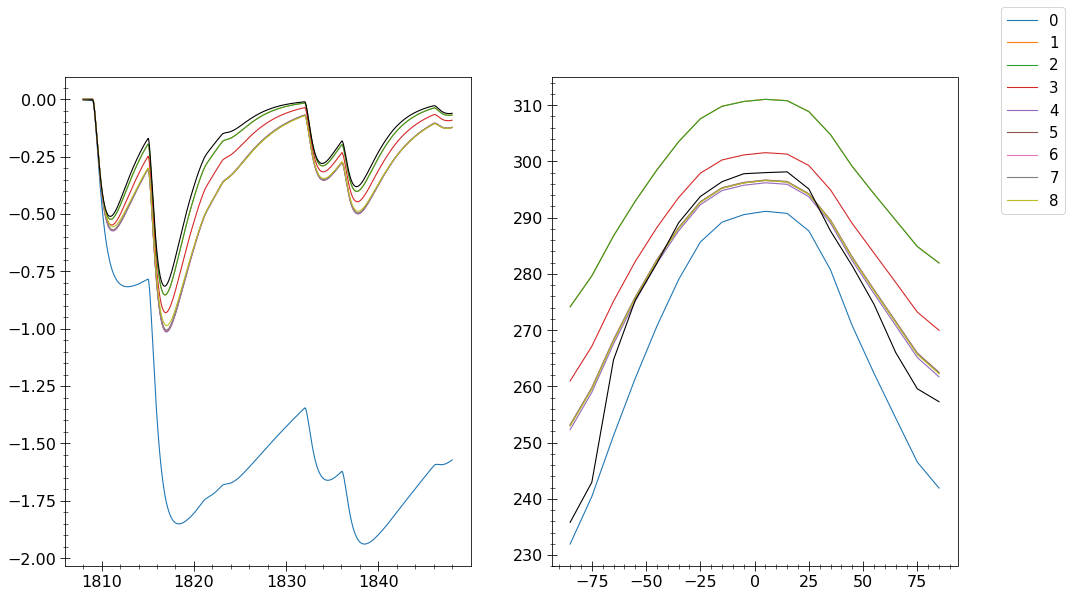

In [20]:
fig,ax=plt.subplots(1,2,figsize=(16,9))
for i in range(9):
    ax[0].plot(Year_volc_1808_1858,data[1][i,0],label=i)
for i in range(9):
    ax[1].plot(Vars.Lat,data[0][i,0])
#plt.plot(Year_volc_1808_1858,data[1,1])
#plt.plot(Year_volc_1808_1858,data[1,2])
#plt.plot(Year_volc_1808_1858,data[1,3])
#plt.plot(Year_volc_1808_1858,data[1,4])
ax[0].plot(Year_volc_1808_1858,EVA_GMT_1808_1858,c='k')
ax[1].plot(Lat_10,ZMT_10,c='k')
plt.figlegend(fontsize=15)
#plt.xlim(1808,1858)
print(gamma)

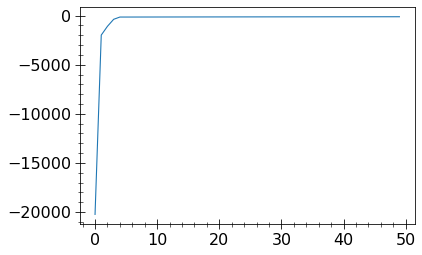

In [13]:
plt.plot(np.arange(50),dF[:,0])

In [31]:
print(gamma)
print(F)
print(dF)
print(P)

[1.00000000e-07 9.99972776e-08 7.96411807e-05 1.25390005e-04
 1.12720129e-04 1.10334142e-04 1.14971662e-04 1.10323682e-03]
[[4908.46279504 4907.68081928 4909.23973105 4895.28385247 4923.48298139
  4823.27040287 5054.43158254 4908.28522758 4908.63776618 4908.43195343
  4908.4941851  4907.80603045 4909.1303077 ]
 [1753.97298698 1753.97300141 1753.97298094 1754.48947943 1753.45663279
  1753.97427467 1753.97169816 1753.9730001  1753.97298007 1753.97303131
  1753.97294266 1753.97350971 1753.97247316]
 [1751.16403766 1751.16404821 1751.16402823 1751.67986844 1750.64831832
  1751.16532353 1751.16274737 1751.16404375 1751.16403319 1751.16407915
  1751.1639929  1751.16454727 1751.16352985]
 [ 276.06893623  276.0685077   276.0693672   276.25742215  275.88053744
   276.07116675  276.06670406  276.07005415  276.06781831  276.06927555
   276.0685969   276.07429964  276.06357283]
 [  90.3567686    90.35446318   90.35907689   90.33866833   90.37496561
    90.35391603   90.35962299   90.35721128   90.

In [18]:
print(70*4.2e6)

294000000.0


In [30]:
print(0.33*np.sum(((data[0][8,0]-target['ZMT'])*np.cos(grid*np.pi/180)/np.mean(np.cos(grid*np.pi/180)))**2))
print(0.66*np.sum(((data[1][8,0]-target['GMT']))**2))

38.13576100244077
45.9309035943473


In [35]:
print(np.sqrt(np.dot(dF[-2],dF[-2])))
print(np.sqrt(np.dot(dF[0],dF[0])))

117.79102151319456
7220029.930903146


In [35]:
#setup={'number_of_parameters': num_params, 'number_of_cycles': 1, 'number_of_parallels': int(num_params*2+1)}
labels=[['eqparam','c_ao'],['func1','m'],['func1','gamma'],['func2','factor_oc'],['func2','factor_kwv'],['func2','factor_kair']]
P=[3.02794273e+08, 4.80868504e-01, 2.47299528e-15, 1.16506701e+00,
 1.16500290e+00, 1.16499030e+00]
#P1=[2.10056979e+08, 5.00042362e-01, 2.01124229e-15, 1.16500050e+00,1.16500009e+00, 1.16500191e+00]
config_CTRL=importer('Dev_Data/Optimization/Volcanic_Sellers_CTRL.ini')
variable_importer(config_CTRL,initialZMT=True,parallel=False)
config_CTRL,ParasCTRL=add_sellersparameters(config_CTRL,\
                                        parameterinterpolatorstepwise,'SellersParameterization.ini',2,0,True,True)
config_CTRL=add_parameters(config_CTRL,P,labels)
data_CTRL=rk4alg(model_equation,config_CTRL['eqparam'],config_CTRL['funccomp'],progressbar=True)
ZMT,GMT=data_CTRL[1][-1],data_CTRL[2][-1]

config_base=importer('Dev_Data/Optimization/Volcanic_Sellers.ini')
variable_importer(config_base,initialZMT=False)
config_base,ParasCTRL=add_sellersparameters(config_base,\
                                    parameterinterpolatorstepwise,'SellersParameterization.ini',2,0,True,True)
config=add_parameters(config_base,P,labels)
Vars.T,Vars.T_global=ZMT,GMT   
data1=rk4alg(model_equation,config['eqparam'],config['funccomp'],progressbar=True)

Loading Configuration from: Dev_Data/Optimization/Volcanic_Sellers_CTRL.ini
Loading Parameters from: /Home/siv32/bsc029/.local/lib/python3.6/site-packages/lowEBMs/Tutorials/Config/Data/SellersParameterization.ini


Loading Configuration from: Dev_Data/Optimization/Volcanic_Sellers.ini
Loading Parameters from: /Home/siv32/bsc029/.local/lib/python3.6/site-packages/lowEBMs/Tutorials/Config/Data/SellersParameterization.ini


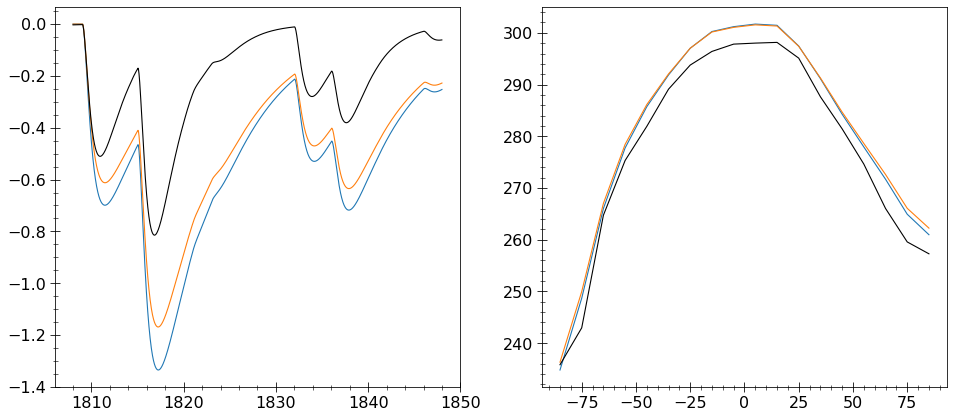

In [36]:
fig,ax=plt.subplots(1,2,figsize=(16,7))
ax[0].plot(data[0]/constants.time_sec_year,data[2]-data[2][0])
ax[0].plot(data1[0]/constants.time_sec_year,data1[2]-data1[2][0])
ax[0].plot(Year_volc_1808_1858,EVA_GMT_1808_1858,c='k')

elevation=-0.0065*np.array(ParasCTRL[1][1])
ax[1].plot(Vars.Lat,data[1][0]+elevation)
ax[1].plot(Vars.Lat,data1[1][0]+elevation)
ax[1].plot(Lat_10,ZMT_10,c='k')

plt.savefig('Coupled_Optimization.eps',format='EPS')

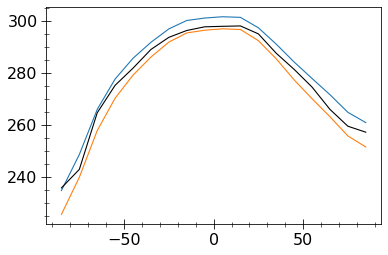

In [25]:
elevation=-0.0065*np.array(ParasCTRL[1][1])
plt.plot(Vars.Lat,data[1][0]+elevation)
plt.plot(Vars.Lat,data1[1][0]+elevation)
plt.plot(Lat_10,ZMT_10,c='k')